<a href="https://colab.research.google.com/github/adrian-deguzman/PyUNET/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %pip install torch torchvision albumentations
# %pip install albumentations tqdm

### Importing libraries

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time
from tqdm import tqdm

In [3]:
# GOOGLE COLAB
# !git clone https://github.com/adrian-deguzman/PyUNET.git
# image_dir = "PyUNET/sessile-main-Kvasir-SEG/images"
# mask_dir = "PyUNET/sessile-main-Kvasir-SEG/masks"

# LOCAL
image_dir = "sessile-main-Kvasir-SEG/images"
mask_dir = "sessile-main-Kvasir-SEG/masks"

if os.path.exists(image_dir):
    print("Directory exists")
else:
    print("Directory does not exist")

Directory exists


In [4]:
torch.cuda.is_available()

True

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

### UNET implementation

In [6]:
class UNET(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        # 161 x 161, output: 160 x 160

        # Down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            # Meaning ba ng dim=1 dito ay one line lang or vector lang ang concatenated tensor?
            concat_skip = torch.cat((skip_connection, x), dim=1)

            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        return x

def test():
    # batch size, # of channels,
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


In [7]:
class KvasirDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 0).astype(np.uint8)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image.float(), mask.long()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


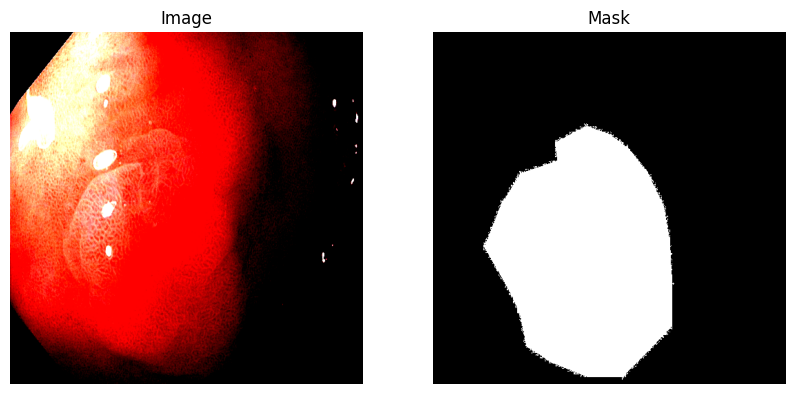

In [8]:
transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Example: Plot one image and its corresponding mask
dataset = KvasirDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
image, mask = dataset[0]  # Get the first image and mask

img_np = (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
mask_np = mask.cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
# expects shape (H, W, C) but image has shape (C, H, W)
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.show()

In [ ]:
# Start the timer
start_time = time.perf_counter()
loss_values = []

learning_rate = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
num_epochs = 3
model = UNET(in_channels=3, out_channels=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

dataset = KvasirDataset(image_dir, mask_dir, transform=transform)

train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

c:\Users\Adrian De Guzman\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Epoch [1/3], Loss: 0.5176


Epoch [2/3], Loss: 0.3566


Epoch [3/3], Loss: 0.3140
Execution time: 1.84 minutes
Avg time per epoch: 0.61 minutes



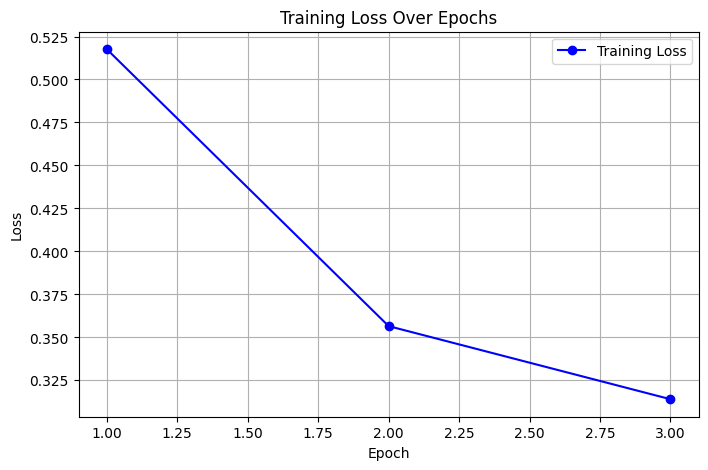

In [11]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    # Wrap the train loader with tqdm for a progress bar
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

# End the timer
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Execution time: {(execution_time) / 60:.2f} minutes")
print(f"Avg time per epoch: {((execution_time / num_epochs) / 60):.2f} minutes")

# Optional: Plot loss graph
print()
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Save the model after training
torch.save(model.state_dict(), "model1.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


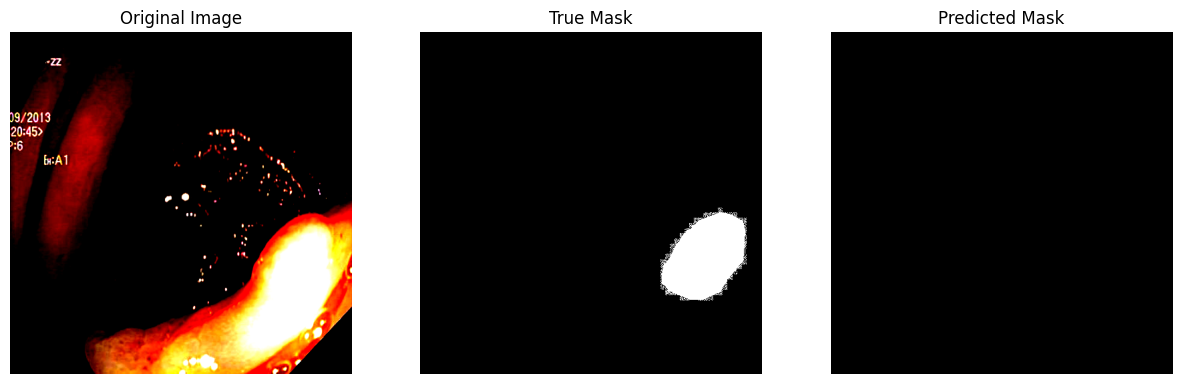

In [16]:
# Select a random sample image and true mask from the dataset
dataset = KvasirDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
image, true_mask = dataset[1]  # You can change index for different samples

# Move image to the device
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Set the model to evaluation mode
model.eval()

# Get model's prediction
with torch.no_grad():
    output = model(image)  # Get raw logits output from the model
    # Apply softmax to convert logits to probabilities and take argmax for segmentation class
    predicted_mask = torch.argmax(output, dim=1).squeeze(0)  # Remove batch dimension

# Convert predicted and true mask to numpy arrays for plotting
true_mask = true_mask.cpu().numpy()
predicted_mask = predicted_mask.cpu().numpy()

# Convert image from tensor to numpy (float for display)
image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

# Plot the image, true mask, and predicted mask
plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

# Plot the true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap="gray")
plt.title("True Mask")
plt.axis('off')

# Plot the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis('off')

plt.show()